In [253]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)


sns.set(font_scale=1.6, style="ticks")



df = pd.read_csv("scenario3-small/haproxy-nginx-wrk")
df = df.set_index('run')

df2 = pd.read_csv("scenario4-big/haproxy-nginx-wrk")
df2 = df2.set_index('run')

# change units
df["wrk-json-requests"] = df["wrk-json-requests"] / 1000 / 10  # k-requests / 10 per second
df["wrk-json-latency-99percentile"] = df["wrk-json-latency-99percentile"] / 1000 / 1000  # µs -> ms -> s
df["cpu_time:haproxy-vnf"] = df["cpu_time:haproxy-vnf"] * 100  # %
df["cpu_time:nginx-vnf"] = df["cpu_time:nginx-vnf"] * 100  # %

df2["wrk-json-requests"] = df2["wrk-json-requests"] / 1000 / 10  # k-requests / 10 per second
df2["wrk-json-latency-99percentile"] = df2["wrk-json-latency-99percentile"] / 1000 / 1000  # µs -> ms -> s
df2["cpu_time:haproxy-vnf"] = df2["cpu_time:haproxy-vnf"] * 100  # %
df2["cpu_time:nginx-vnf"] = df2["cpu_time:nginx-vnf"] * 100  # %

# select
df = df[df["memory:haproxy-vnf"] == 128]
df = df[df["memory:nginx-vnf"] == 128]
df = df[df["vcpus:haproxy-vnf"] == 1]
df = df[df["vcpus:nginx-vnf"] == 1]

df2 = df2[df2["memory:haproxy-vnf"] == 128]
df2 = df2[df2["memory:nginx-vnf"] == 128]
df2 = df2[df2["vcpus:haproxy-vnf"] == 1]
df2 = df2[df2["vcpus:nginx-vnf"] == 1]




print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90 entries, 0 to 509
Data columns (total 11 columns):
vcpus:haproxy-vnf                90 non-null int64
memory:haproxy-vnf               90 non-null int64
storage:haproxy-vnf              90 non-null int64
cpu_time:haproxy-vnf             90 non-null float64
vcpus:nginx-vnf                  90 non-null int64
memory:nginx-vnf                 90 non-null int64
storage:nginx-vnf                90 non-null int64
cpu_time:nginx-vnf               90 non-null float64
wrk-json-bytes                   90 non-null int64
wrk-json-latency-99percentile    90 non-null float64
wrk-json-requests                90 non-null float64
dtypes: float64(4), int64(7)
memory usage: 8.4 KB
None


,vcpus:haproxy-vnf,memory:haproxy-vnf,storage:haproxy-vnf,cpu_time:haproxy-vnf,vcpus:nginx-vnf,memory:nginx-vnf,storage:nginx-vnf,cpu_time:nginx-vnf,wrk-json-bytes,wrk-json-latency-99percentile,wrk-json-requests
run,,,,,,,,,,,
0,1,128,10,10.0,1,128,10,10.0,3295735,0.943414,0.9285
1,1,128,10,10.0,1,128,10,10.0,3094120,0.944422,0.8717
2,1,128,10,10.0,1,128,10,10.0,3155170,0.945766,0.8889
3,1,128,10,10.0,1,128,10,10.0,3243565,0.943624,0.9138
4,1,128,10,10.0,1,128,10,10.0,3147365,0.945627,0.8867


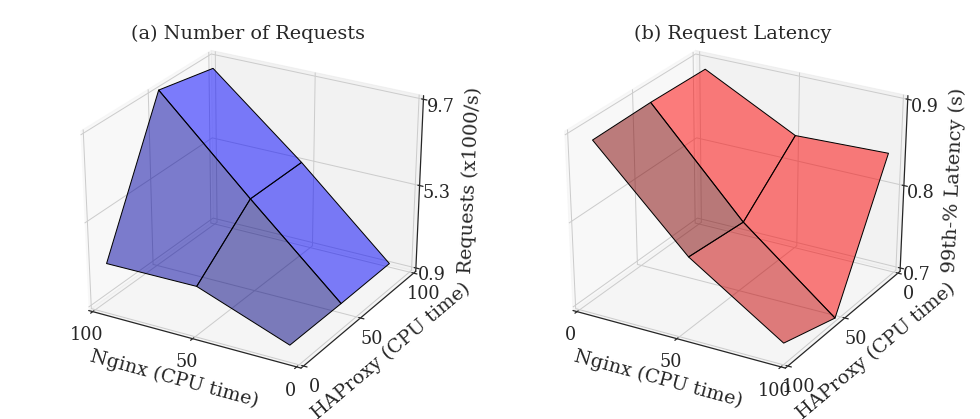

In [259]:
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"


def plot_3d(ax, d, x_col, y_col, z_col, z_label, title, color="blue", x_lim=(100, 0), y_lim=(0, 100)):
    # 2D-arrays from DataFrame
    x1 = np.linspace(d[x_col].min(), d[x_col].max(), len(d[x_col].unique()))
    y1 = np.linspace(d[y_col].min(), d[y_col].max(), len(d[y_col].unique()))
    """
    x, y via meshgrid for vectorized evaluation of
    2 scalar/vector fields over 2-D grids, given
    one-dimensional coordinate arrays x1, x2,..., xn.
    """
    x2, y2 = np.meshgrid(x1, y1)
    # Interpolate unstructured D-dimensional data.
    z2 = griddata((d[x_col], d[y_col]), d[z_col], (x2, y2), method='cubic')
    
    surf = ax.plot_surface(x2, y2, z2, rstride=1, cstride=1, #cmap=cm.coolwarm,
                       linewidth=1, edgecolors="black", antialiased=True, color=color, alpha=0.5, shade=True)
    #ax.set_zlim(-1.01, 1.01)
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    ax.xaxis.set_major_locator(LinearLocator(3))
    ax.yaxis.set_major_locator(LinearLocator(3))
    ax.zaxis.set_major_locator(LinearLocator(3))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.01f'))
    ax.set_xlabel('Nginx (CPU time)')
    ax.set_ylabel('HAProxy (CPU time)')
    ax.set_zlabel(z_label)
    ax.xaxis.labelpad=12
    ax.yaxis.labelpad=12
    ax.zaxis.labelpad=14
    ax.dist = 10.8
    ax.set_title(title)
    
# Ready to plot
fig = plt.figure()
fig.set_size_inches(14, 6.2)
ax = fig.add_subplot(1, 2, 1, projection='3d') #fig.gca(projection='3d')
plot_3d(ax, df, "cpu_time:nginx-vnf", "cpu_time:haproxy-vnf", "wrk-json-requests", z_label="Requests (x1000/s)", title="(a) Number of Requests")
#plot_3d(ax, df2, "cpu_time:nginx-vnf", "cpu_time:haproxy-vnf", "wrk-json-requests", z_label="Requests (x1000/s)", title="(a) Number of Requests")

ax = fig.add_subplot(1, 2, 2, projection='3d')
plot_3d(ax, df, "cpu_time:nginx-vnf", "cpu_time:haproxy-vnf", "wrk-json-latency-99percentile", z_label="99th-% Latency (s)", title="(b) Request Latency", color="red", x_lim=(0, 100), y_lim=(100, 0))
#plot_3d(ax, df2, "cpu_time:nginx-vnf", "cpu_time:haproxy-vnf", "wrk-json-latency-99percentile", z_label="99th-% Latency (s)", title="(b) Request Latency", color="red", x_lim=(0, 100), y_lim=(100, 0))


#fig.subplots_adjust(left=0, right=0.1, bottom=0, top=1)
#fig.colorbar(surf, shrink=0.5, aspect=5)
#plt.title('Meshgrid Created from 3 1D Arrays')
plt.tight_layout()
plt.subplots_adjust(wspace=.03)
fig.savefig("plot_3d_combined.pdf", dpi=300)
plt.show()